# VAE for Music Clustering - Exploratory Analysis

**Course:** Neural Networks  
**Project:** Unsupervised Learning with VAE for Hybrid Language Music Clustering  
**Prepared By:** Dipto Sumit  
**Date:** January 10, 2026

---

This notebook explores the GTZAN music dataset and implements a Variational Autoencoder (VAE) based clustering pipeline to discover musical genres.

## Dataset Overview
- **GTZAN Genre Collection**: 1000 audio tracks across 10 genres
- **Genres**: Blues, Classical, Country, Disco, Hip-hop, Jazz, Metal, Pop, Reggae, Rock
- **Features**: Pre-extracted audio features including MFCCs, spectral features, chroma, etc.

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import os
import sys

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score, 
    calinski_harabasz_score, 
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Progress bar
from tqdm import tqdm

# Add src to path
sys.path.append('../src')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset Structure

In [2]:
# Define data paths
DATA_DIR = '../archive/Data'
FEATURES_PATH = os.path.join(DATA_DIR, 'features_30_sec.csv')
GENRES_DIR = os.path.join(DATA_DIR, 'genres_original')

# Check if data exists
print(f"Data directory exists: {os.path.exists(DATA_DIR)}")
print(f"Features file exists: {os.path.exists(FEATURES_PATH)}")
print(f"Genres directory exists: {os.path.exists(GENRES_DIR)}")

# List all genres
if os.path.exists(GENRES_DIR):
    genres = sorted([d for d in os.listdir(GENRES_DIR) if os.path.isdir(os.path.join(GENRES_DIR, d))])
    print(f"\nTotal genres: {len(genres)}")
    print(f"Genres: {genres}")
    
    # Count files per genre
    print("\nFiles per genre:")
    for genre in genres:
        genre_path = os.path.join(GENRES_DIR, genre)
        n_files = len([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        print(f"  {genre:12s}: {n_files} files")

Data directory exists: True
Features file exists: True
Genres directory exists: True

Total genres: 10
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Files per genre:
  blues       : 100 files
  classical   : 100 files
  country     : 100 files
  disco       : 100 files
  hiphop      : 100 files
  jazz        : 100 files
  metal       : 100 files
  pop         : 100 files
  reggae      : 100 files
  rock        : 100 files


## 3. Load Audio Features from CSV

In [3]:
# Load features CSV
df = pd.read_csv(FEATURES_PATH)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
Shape: (1000, 60)

First few rows:


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## 4. Exploratory Data Analysis

In [4]:
# Basic information
print("="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"\nShape: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes.value_counts()}")
print(f"\nMissing values:\n{df.isnull().sum().sum()} total missing values")

# Genre distribution
print(f"\nGenre distribution:")
print(df['label'].value_counts().sort_index())

# Basic statistics
print(f"\nBasic statistics of first few features:")
df.iloc[:, 2:7].describe()

DATASET INFORMATION

Shape: 1000 samples, 60 features

Column names:
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean', 'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var', 'label']

Data types:
f

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.378682,0.086340,0.130930,0.003051,2201.780898
std,0.081705,0.007735,0.065683,0.003634,715.960600
min,0.171939,0.044555,0.005276,0.000004,570.040355
25%,0.319562,0.082298,0.086657,0.000942,1627.697311
50%,0.383148,0.086615,0.122443,0.001816,2209.263090
75%,0.435942,0.091256,0.175682,0.003577,2691.294667
max,0.663685,0.108111,0.397973,0.027679,4435.243901


### 4.1 Visualize Genre Distribution

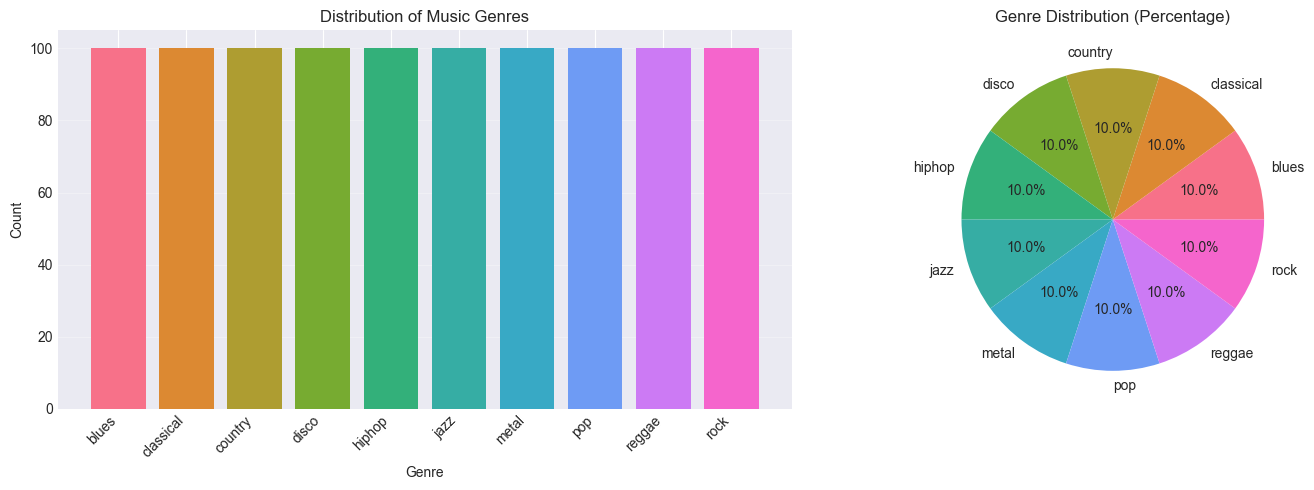

Balanced dataset: True


In [5]:
# Plot genre distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
genre_counts = df['label'].value_counts().sort_index()
axes[0].bar(range(len(genre_counts)), genre_counts.values, color=sns.color_palette("husl", len(genre_counts)))
axes[0].set_xticks(range(len(genre_counts)))
axes[0].set_xticklabels(genre_counts.index, rotation=45, ha='right')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Music Genres')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', 
            colors=sns.color_palette("husl", len(genre_counts)))
axes[1].set_title('Genre Distribution (Percentage)')

plt.tight_layout()
plt.show()

print(f"Balanced dataset: {genre_counts.std() < 5}")

### 4.2 Feature Correlation Analysis

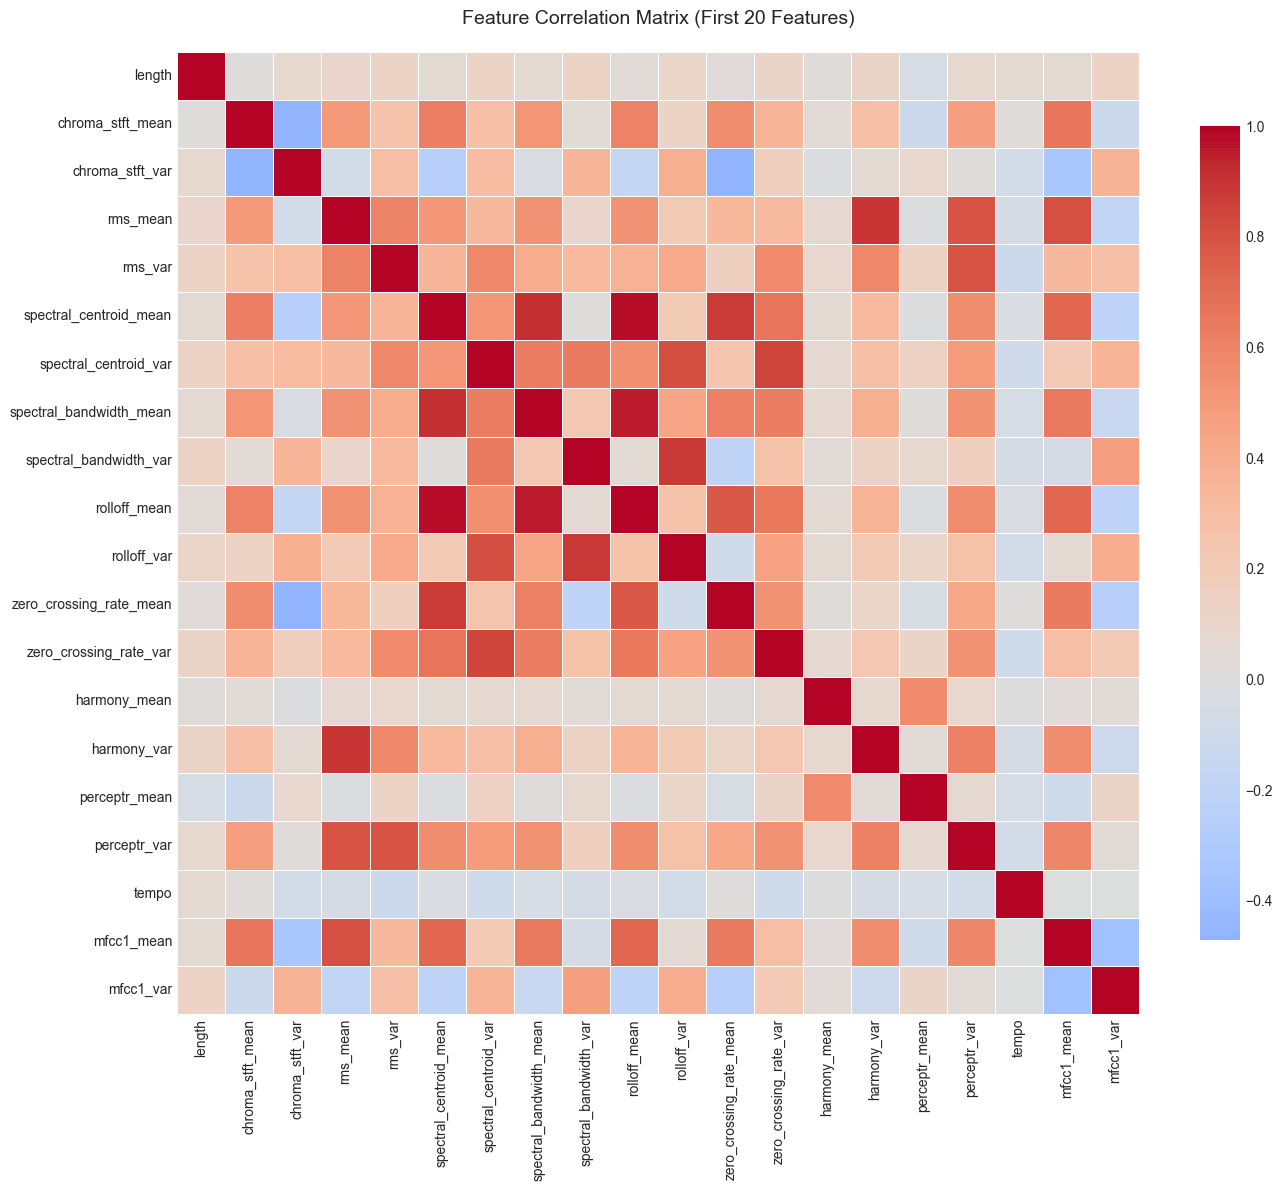


Highly correlated feature pairs (|correlation| > 0.8): 9
  rms_mean <-> harmony_var: 0.894
  rms_mean <-> mfcc1_mean: 0.807
  spectral_centroid_mean <-> spectral_bandwidth_mean: 0.904
  spectral_centroid_mean <-> rolloff_mean: 0.980
  spectral_centroid_mean <-> zero_crossing_rate_mean: 0.875


In [6]:
# Select numerical features (excluding filename and label)
numeric_cols = df.select_dtypes(include=[np.number]).columns[:20]  # First 20 for visualization

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (First 20 Features)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(f"\nHighly correlated feature pairs (|correlation| > 0.8): {len(high_corr_pairs)}")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

## 5. Data Preprocessing

In [9]:
# Import from our modules
from dataset import MusicDataLoader
from vae import SimpleVAE, ConvVAE, BetaVAE
from clustering import MusicClusterer, BaselineClustering
from evaluation import compute_all_metrics, ClusteringEvaluator
from visualization import (
    plot_latent_space_tsne, 
    plot_latent_space_umap,
    plot_cluster_distribution,
    plot_training_loss,
    plot_metric_comparison
)

# Load and preprocess data
data_loader = MusicDataLoader(FEATURES_PATH, test_size=0.2, random_state=42)

# Get full dataset with scaling
X_scaled, y_labels = data_loader.get_full_dataset(scale=True)

# Get train/test split
X_train, X_test, y_train, y_test = data_loader.get_train_test_split(scale=True)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of genres: {len(np.unique(y_labels))}")

Loaded 1000 samples with 57 features
Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
Samples per genre: 100
Training set: (800, 57)
Test set: (200, 57)
Number of features: 57
Number of genres: 10


## 6. Easy Task: Basic VAE with K-Means Clustering

In [10]:
# Initialize Simple VAE
input_dim = X_train.shape[1]
latent_dim = 32
hidden_dims = [256, 128]

simple_vae = SimpleVAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simple_vae.to(device)

print(f"Device: {device}")
print(f"Model: {simple_vae.__class__.__name__}")
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"\nModel architecture:")
print(simple_vae)

Device: cpu
Model: SimpleVAE
Input dimension: 57
Latent dimension: 32

Model architecture:
SimpleVAE(
  (encoder): Sequential(
    (0): Linear(in_features=57, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
  )
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNor

### 6.1 Train Simple VAE

In [11]:
# Training function
def train_vae(model, train_data, epochs=50, batch_size=64, lr=1e-3, beta=1.0):
    """Train VAE model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    # Create data loader
    train_loader = data_loader.get_dataloader(train_data, batch_size=batch_size, shuffle=True)
    
    losses = {'total': [], 'recon': [], 'kl': []}
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_recon = 0
        epoch_kl = 0
        
        for batch in train_loader:
            if isinstance(batch, tuple):
                batch_data = batch[0]
            else:
                batch_data = batch
                
            batch_data = batch_data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(batch_data)
            
            # Compute loss
            loss, recon_loss, kl_loss = model.loss_function(recon_batch, batch_data, mu, logvar, beta=beta)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
        
        # Average losses
        avg_loss = epoch_loss / len(train_loader.dataset)
        avg_recon = epoch_recon / len(train_loader.dataset)
        avg_kl = epoch_kl / len(train_loader.dataset)
        
        losses['total'].append(avg_loss)
        losses['recon'].append(avg_recon)
        losses['kl'].append(avg_kl)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')
    
    return losses

# Train the model
print("Training Simple VAE...")
vae_losses = train_vae(simple_vae, X_train, epochs=50, batch_size=64, lr=1e-3)
print("Training completed!")

Training Simple VAE...
Epoch [10/50], Loss: 40.6603, Recon: 32.3846, KL: 8.2757
Epoch [20/50], Loss: 37.7856, Recon: 29.6438, KL: 8.1418
Epoch [30/50], Loss: 34.6791, Recon: 26.4313, KL: 8.2478
Epoch [40/50], Loss: 34.0195, Recon: 25.7050, KL: 8.3145
Epoch [50/50], Loss: 32.6644, Recon: 24.4757, KL: 8.1887
Training completed!


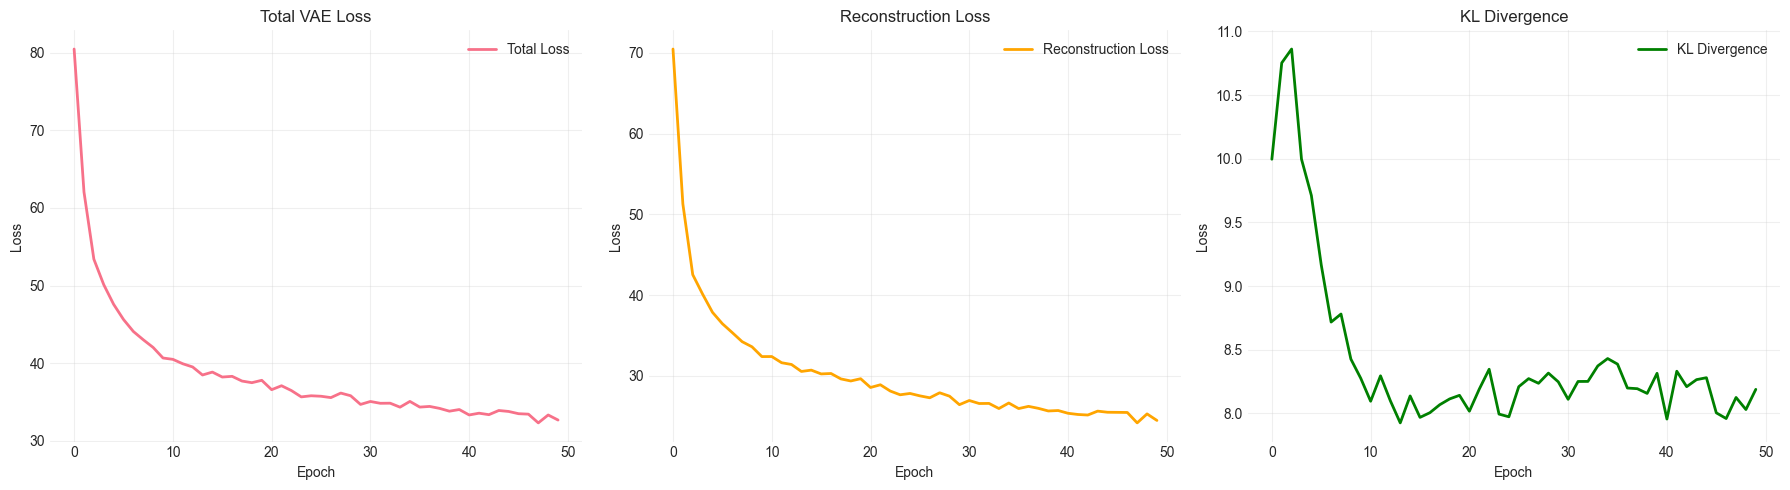

In [12]:
# Plot training losses
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(vae_losses['total'], label='Total Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total VAE Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(vae_losses['recon'], label='Reconstruction Loss', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(vae_losses['kl'], label='KL Divergence', color='green', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Extract Latent Representations

In [13]:
# Extract latent representations
simple_vae.eval()
with torch.no_grad():
    X_scaled_torch = torch.FloatTensor(X_scaled).to(device)
    vae_latent = simple_vae.get_latent(X_scaled_torch).cpu().numpy()
    
print(f"Latent representation shape: {vae_latent.shape}")
print(f"Latent dimension: {vae_latent.shape[1]}")
print(f"Original dimension: {X_scaled.shape[1]}")
print(f"Dimension reduction: {X_scaled.shape[1] / vae_latent.shape[1]:.1f}x")

Latent representation shape: (1000, 32)
Latent dimension: 32
Original dimension: 57
Dimension reduction: 1.8x


### 6.3 K-Means Clustering on VAE Latent Space

In [14]:
# Perform K-Means clustering on VAE latent space
n_clusters = 10  # Number of genres
kmeans_vae = MusicClusterer(method='kmeans', n_clusters=n_clusters, random_state=42)
vae_cluster_labels = kmeans_vae.fit(vae_latent)

print(f"K-Means clustering on VAE latent space:")
print(f"Number of clusters: {n_clusters}")
print(f"Cluster distribution:")
unique, counts = np.unique(vae_cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples")

K-Means clustering on VAE latent space:
Number of clusters: 10
Cluster distribution:
  Cluster 0: 39 samples
  Cluster 1: 232 samples
  Cluster 2: 184 samples
  Cluster 3: 31 samples
  Cluster 4: 81 samples
  Cluster 5: 66 samples
  Cluster 6: 99 samples
  Cluster 7: 98 samples
  Cluster 8: 46 samples
  Cluster 9: 124 samples


### 6.4 Visualize Latent Space with t-SNE

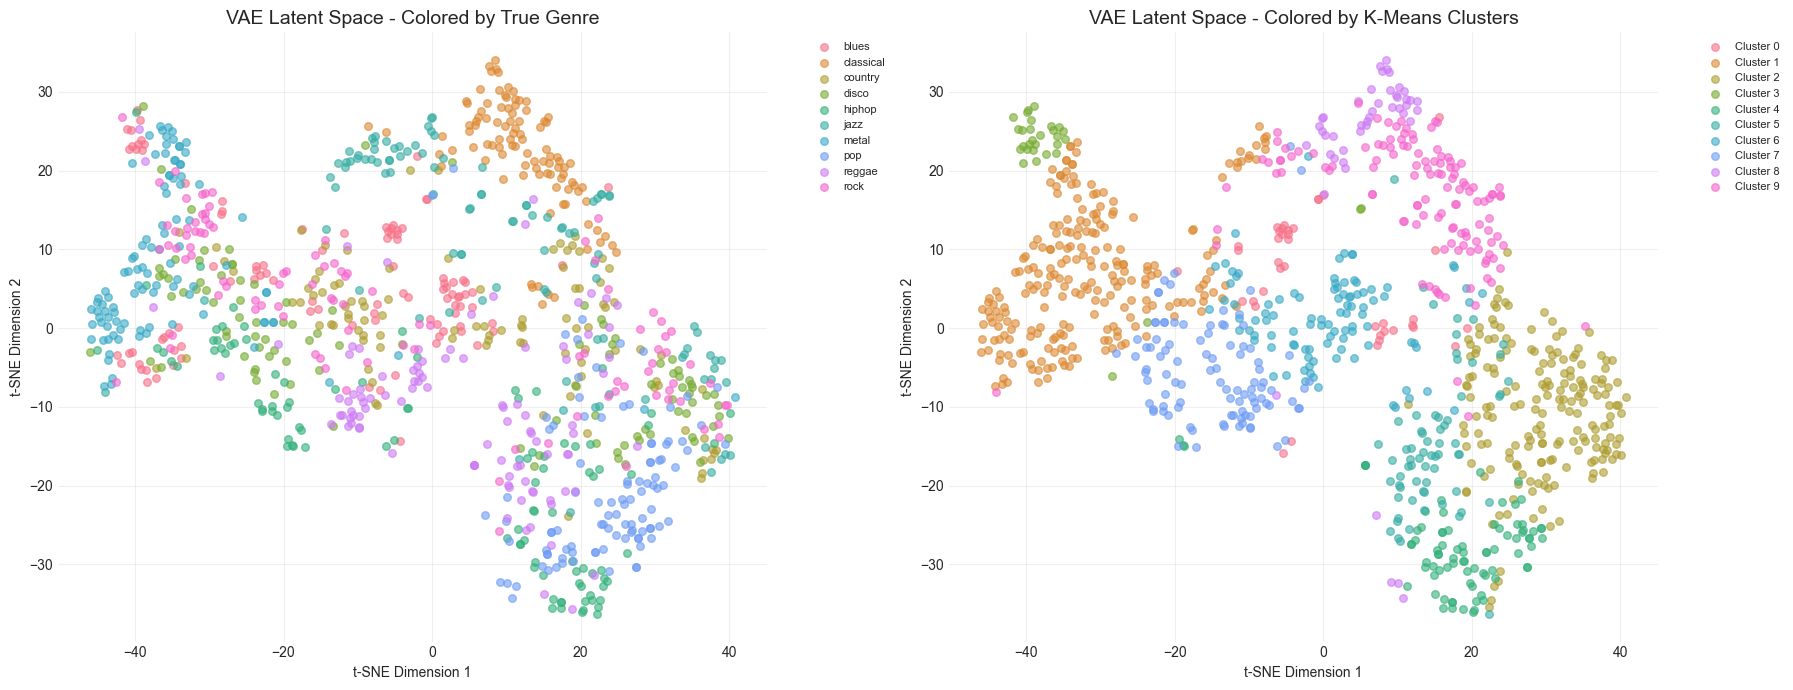

In [16]:
# Apply t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
vae_tsne = tsne.fit_transform(vae_latent)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot by true genre labels
genre_names = data_loader.label_names
colors = sns.color_palette("husl", len(genre_names))
for i, genre in enumerate(genre_names):
    mask = y_labels == i
    axes[0].scatter(vae_tsne[mask, 0], vae_tsne[mask, 1], 
                   c=[colors[i]], label=genre, alpha=0.6, s=30)
axes[0].set_title('VAE Latent Space - Colored by True Genre', fontsize=14)
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(alpha=0.3)

# Plot by predicted clusters
cluster_colors = sns.color_palette("husl", n_clusters)
for cluster_id in range(n_clusters):
    mask = vae_cluster_labels == cluster_id
    axes[1].scatter(vae_tsne[mask, 0], vae_tsne[mask, 1],
                   c=[cluster_colors[cluster_id]], label=f'Cluster {cluster_id}', alpha=0.6, s=30)
axes[1].set_title('VAE Latent Space - Colored by K-Means Clusters', fontsize=14)
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.5 Baseline: PCA + K-Means

Baseline PCA + K-Means clustering:
Number of PCA components: 32
Number of clusters: 10
Explained variance ratio: [0.23949564 0.16929248 0.10750028 0.07601962 0.04578077]
Total explained variance: 0.9482


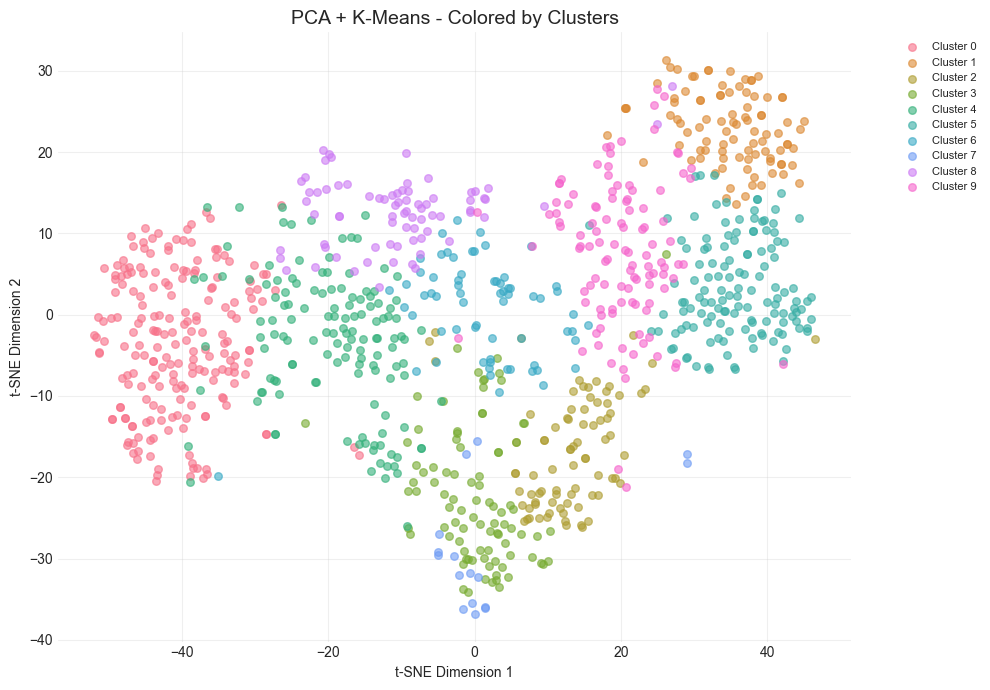

In [17]:
# Baseline: PCA + K-Means
baseline = BaselineClustering(n_components=latent_dim, n_clusters=n_clusters, random_state=42)
baseline_labels = baseline.fit(X_scaled)

print(f"Baseline PCA + K-Means clustering:")
print(f"Number of PCA components: {latent_dim}")
print(f"Number of clusters: {n_clusters}")
print(f"Explained variance ratio: {baseline.get_explained_variance_ratio()[:5]}")
print(f"Total explained variance: {sum(baseline.get_explained_variance_ratio()):.4f}")

# Get PCA features for visualization
pca_features = baseline.transform(X_scaled)

# Apply t-SNE to PCA features
pca_tsne = tsne.fit_transform(pca_features)

# Visualize PCA clustering
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for cluster_id in range(n_clusters):
    mask = baseline_labels == cluster_id
    ax.scatter(pca_tsne[mask, 0], pca_tsne[mask, 1],
               c=[cluster_colors[cluster_id]], label=f'Cluster {cluster_id}', alpha=0.6, s=30)
ax.set_title('PCA + K-Means - Colored by Clusters', fontsize=14)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 6.6 Evaluation and Comparison

In [18]:
# Compute metrics for both methods
from evaluation import compute_all_metrics

# VAE + K-Means
vae_metrics = compute_all_metrics(vae_latent, vae_cluster_labels, y_labels)

# PCA + K-Means
pca_metrics = compute_all_metrics(pca_features, baseline_labels, y_labels)

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index', 
               'Adjusted Rand Index', 'NMI'],
    'VAE + K-Means': [
        vae_metrics['silhouette_score'],
        vae_metrics['calinski_harabasz_score'],
        vae_metrics['davies_bouldin_score'],
        vae_metrics['adjusted_rand_score'],
        vae_metrics['nmi_score']
    ],
    'PCA + K-Means': [
        pca_metrics['silhouette_score'],
        pca_metrics['calinski_harabasz_score'],
        pca_metrics['davies_bouldin_score'],
        pca_metrics['adjusted_rand_score'],
        pca_metrics['nmi_score']
    ]
})

print("="*80)
print("CLUSTERING EVALUATION - EASY TASK")
print("="*80)
print("\nComparison of VAE + K-Means vs PCA + K-Means:\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Determine winner for each metric
comparison_df['Better'] = comparison_df.apply(
    lambda row: 'VAE' if (row['VAE + K-Means'] > row['PCA + K-Means'] and row['Metric'] != 'Davies-Bouldin Index')
                     or (row['VAE + K-Means'] < row['PCA + K-Means'] and row['Metric'] == 'Davies-Bouldin Index')
                else 'PCA',
    axis=1
)

print(f"\nSummary:")
vae_wins = (comparison_df['Better'] == 'VAE').sum()
pca_wins = (comparison_df['Better'] == 'PCA').sum()
print(f"VAE + K-Means wins on {vae_wins}/5 metrics")
print(f"PCA + K-Means wins on {pca_wins}/5 metrics")

CLUSTERING EVALUATION - EASY TASK

Comparison of VAE + K-Means vs PCA + K-Means:

                 Metric  VAE + K-Means  PCA + K-Means
       Silhouette Score       0.210063       0.121149
Calinski-Harabasz Index     132.025357     108.744476
   Davies-Bouldin Index       1.520584       2.008218
    Adjusted Rand Index       0.159287       0.176222
                    NMI       0.311523       0.320886


Summary:
VAE + K-Means wins on 3/5 metrics
PCA + K-Means wins on 2/5 metrics


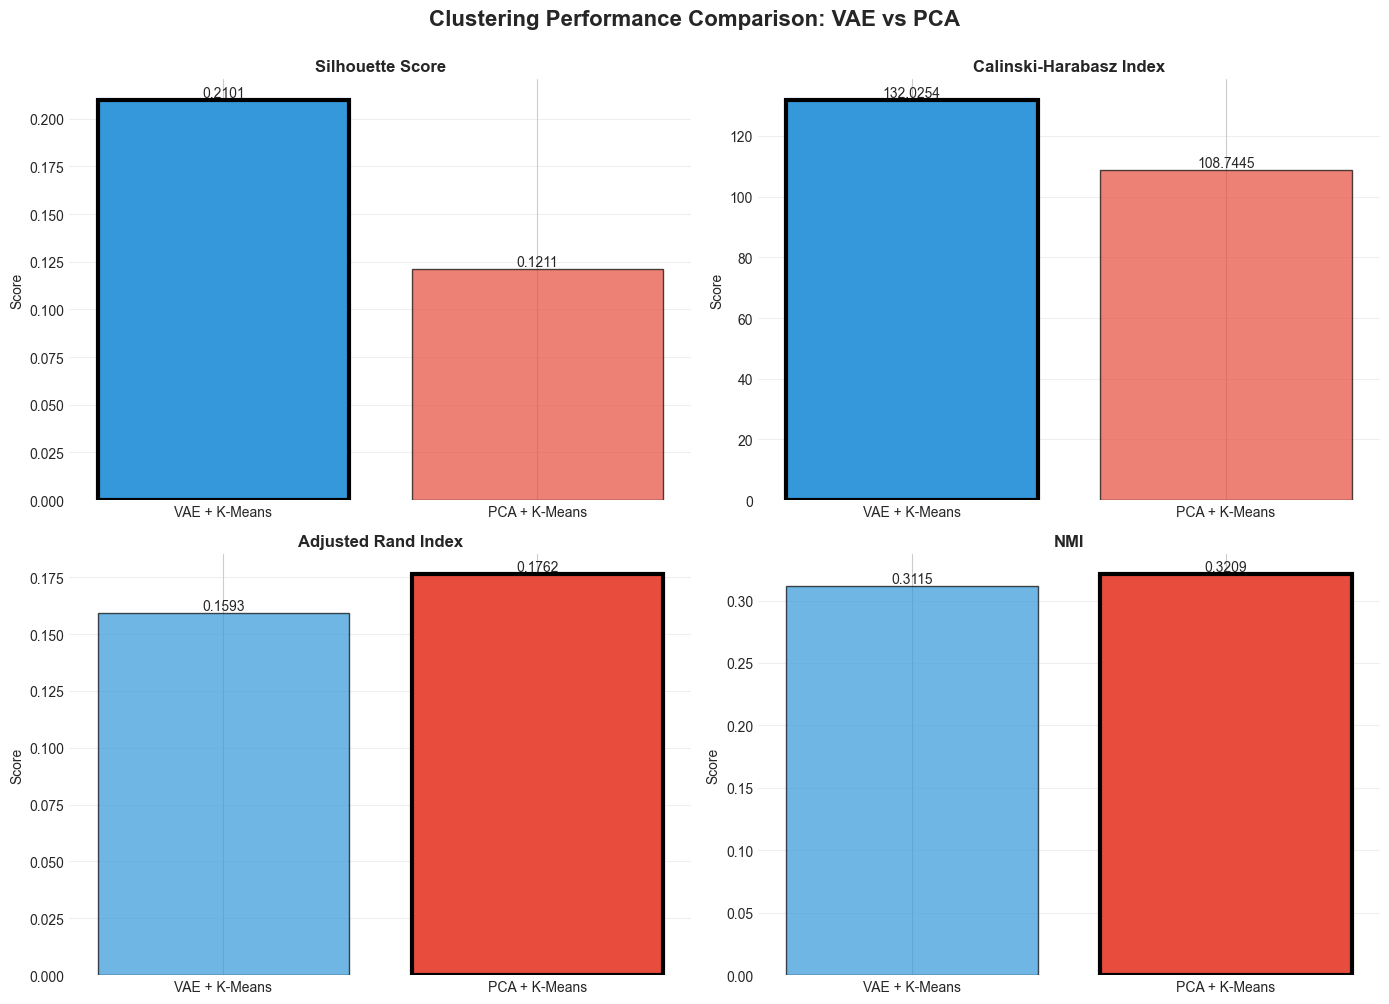

In [19]:
# Visualize metric comparison
metrics_to_plot = ['Silhouette Score', 'Calinski-Harabasz Index', 'Adjusted Rand Index', 'NMI']
comparison_subset = comparison_df[comparison_df['Metric'].isin(metrics_to_plot)]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (ax, metric) in enumerate(zip(axes, metrics_to_plot)):
    row = comparison_subset[comparison_subset['Metric'] == metric].iloc[0]
    values = [row['VAE + K-Means'], row['PCA + K-Means']]
    bars = ax.bar(['VAE + K-Means', 'PCA + K-Means'], values, 
                   color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
    
    # Highlight the better method
    better_idx = 0 if row['Better'] == 'VAE' else 1
    bars[better_idx].set_alpha(1.0)
    bars[better_idx].set_linewidth(3)
    
    ax.set_ylabel('Score')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Clustering Performance Comparison: VAE vs PCA', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Medium Task: Convolutional VAE with Multiple Clustering Algorithms

In [20]:
# Train Convolutional VAE
conv_vae = ConvVAE(input_dim=input_dim, latent_dim=64, channels=[32, 64, 128])
conv_vae.to(device)

print(f"Convolutional VAE initialized")
print(f"Input dimension: {input_dim}")
print(f"Latent dimension: 64")
print(f"Channels: [32, 64, 128]")
print("\nTraining ConvVAE...")

conv_losses = train_vae(conv_vae, X_train, epochs=50, batch_size=64, lr=1e-3)
print("Training completed!")

Convolutional VAE initialized
Input dimension: 57
Latent dimension: 64
Channels: [32, 64, 128]

Training ConvVAE...
Epoch [10/50], Loss: 81.0298, Recon: 62.8319, KL: 18.1979
Epoch [20/50], Loss: 61.1362, Recon: 48.1133, KL: 13.0229
Epoch [30/50], Loss: 50.6842, Recon: 39.6132, KL: 11.0710
Epoch [40/50], Loss: 44.5346, Recon: 34.1137, KL: 10.4209
Epoch [50/50], Loss: 41.8186, Recon: 31.7179, KL: 10.1007
Training completed!


In [21]:
# Extract latent features from ConvVAE
conv_vae.eval()
with torch.no_grad():
    conv_latent = conv_vae.get_latent(X_scaled_torch).cpu().numpy()

print(f"ConvVAE Latent representation shape: {conv_latent.shape}")

# Apply multiple clustering algorithms
clustering_methods = {
    'K-Means': MusicClusterer('kmeans', n_clusters=10, random_state=42),
    'Agglomerative (Ward)': MusicClusterer('agglomerative', n_clusters=10, linkage='ward'),
    'Agglomerative (Complete)': MusicClusterer('agglomerative', n_clusters=10, linkage='complete'),
}

results = {}
for name, clusterer in clustering_methods.items():
    labels = clusterer.fit(conv_latent)
    metrics = compute_all_metrics(conv_latent, labels, y_labels)
    results[name] = metrics
    print(f"\n{name}:")
    print(f"  Silhouette: {metrics['silhouette_score']:.4f}")
    print(f"  ARI: {metrics['adjusted_rand_score']:.4f}")
    print(f"  NMI: {metrics['nmi_score']:.4f}")

ConvVAE Latent representation shape: (1000, 64)

K-Means:
  Silhouette: 0.1667
  ARI: 0.1769
  NMI: 0.3281

Agglomerative (Ward):
  Silhouette: 0.1612
  ARI: 0.1772
  NMI: 0.3261

Agglomerative (Complete):
  Silhouette: 0.1815
  ARI: 0.0843
  NMI: 0.2365


## 8. Hard Task: Beta-VAE for Disentangled Representations

In [22]:
# Train Beta-VAE with higher beta for disentanglement
beta_vae = BetaVAE(input_dim=input_dim, latent_dim=64, hidden_dims=[256, 128], beta=4.0)
beta_vae.to(device)

print(f"Beta-VAE initialized with beta=4.0")
print("Training Beta-VAE...")

beta_losses = train_vae(beta_vae, X_train, epochs=50, batch_size=64, lr=1e-3, beta=4.0)
print("Training completed!")

Beta-VAE initialized with beta=4.0
Training Beta-VAE...
Epoch [10/50], Loss: 58.1884, Recon: 42.9003, KL: 3.8220
Epoch [20/50], Loss: 52.3931, Recon: 40.5696, KL: 2.9559
Epoch [30/50], Loss: 48.8077, Recon: 38.4342, KL: 2.5934
Epoch [40/50], Loss: 48.4510, Recon: 38.8080, KL: 2.4107
Epoch [50/50], Loss: 46.7705, Recon: 37.7838, KL: 2.2467
Training completed!


In [23]:
# Extract Beta-VAE latent features and cluster
beta_vae.eval()
with torch.no_grad():
    beta_latent = beta_vae.get_latent(X_scaled_torch).cpu().numpy()

# Cluster with K-Means
beta_kmeans = MusicClusterer('kmeans', n_clusters=10, random_state=42)
beta_labels = beta_kmeans.fit(beta_latent)

# Evaluate
beta_metrics = compute_all_metrics(beta_latent, beta_labels, y_labels)

print("Beta-VAE Clustering Results:")
print(f"  Silhouette: {beta_metrics['silhouette_score']:.4f}")
print(f"  Calinski-Harabasz: {beta_metrics['calinski_harabasz_score']:.2f}")
print(f"  Davies-Bouldin: {beta_metrics['davies_bouldin_score']:.4f}")
print(f"  ARI: {beta_metrics['adjusted_rand_score']:.4f}")
print(f"  NMI: {beta_metrics['nmi_score']:.4f}")
print(f"  Purity: {beta_metrics['purity']:.4f}")

Beta-VAE Clustering Results:
  Silhouette: 0.3067
  Calinski-Harabasz: 456.30
  Davies-Bouldin: 1.0811
  ARI: 0.1646
  NMI: 0.2991
  Purity: 0.3690


## 9. Final Comparison and Conclusions

In [24]:
# Comprehensive comparison of all methods
final_comparison = pd.DataFrame({
    'Method': ['PCA + K-Means', 'Simple VAE + K-Means', 'Conv VAE + K-Means', 'Beta-VAE + K-Means'],
    'Silhouette': [
        pca_metrics['silhouette_score'],
        vae_metrics['silhouette_score'],
        results['K-Means']['silhouette_score'],
        beta_metrics['silhouette_score']
    ],
    'Calinski-Harabasz': [
        pca_metrics['calinski_harabasz_score'],
        vae_metrics['calinski_harabasz_score'],
        results['K-Means']['calinski_harabasz_score'],
        beta_metrics['calinski_harabasz_score']
    ],
    'Davies-Bouldin': [
        pca_metrics['davies_bouldin_score'],
        vae_metrics['davies_bouldin_score'],
        results['K-Means']['davies_bouldin_score'],
        beta_metrics['davies_bouldin_score']
    ],
    'ARI': [
        pca_metrics['adjusted_rand_score'],
        vae_metrics['adjusted_rand_score'],
        results['K-Means']['adjusted_rand_score'],
        beta_metrics['adjusted_rand_score']
    ],
    'NMI': [
        pca_metrics['nmi_score'],
        vae_metrics['nmi_score'],
        results['K-Means']['nmi_score'],
        beta_metrics['nmi_score']
    ],
    'Purity': [
        pca_metrics['purity'],
        vae_metrics['purity'],
        results['K-Means']['purity'],
        beta_metrics['purity']
    ]
})

print("="*100)
print("FINAL COMPARISON OF ALL METHODS")
print("="*100)
print(final_comparison.to_string(index=False))
print("="*100)

# Find best method for each metric
print("\nBest Method per Metric:")
for col in final_comparison.columns[1:]:
    if col == 'Davies-Bouldin':
        best_idx = final_comparison[col].idxmin()
    else:
        best_idx = final_comparison[col].idxmax()
    best_method = final_comparison.loc[best_idx, 'Method']
    best_value = final_comparison.loc[best_idx, col]
    print(f"  {col:20s}: {best_method:25s} ({best_value:.4f})")

FINAL COMPARISON OF ALL METHODS
              Method  Silhouette  Calinski-Harabasz  Davies-Bouldin      ARI      NMI  Purity
       PCA + K-Means    0.121149         108.744476        2.008218 0.176222 0.320886   0.391
Simple VAE + K-Means    0.210063         132.025357        1.520584 0.159287 0.311523   0.368
  Conv VAE + K-Means    0.166729         152.798271        1.745741 0.176872 0.328058   0.393
  Beta-VAE + K-Means    0.306660         456.302058        1.081054 0.164626 0.299103   0.369

Best Method per Metric:
  Silhouette          : Beta-VAE + K-Means        (0.3067)
  Calinski-Harabasz   : Beta-VAE + K-Means        (456.3021)
  Davies-Bouldin      : Beta-VAE + K-Means        (1.0811)
  ARI                 : Conv VAE + K-Means        (0.1769)
  NMI                 : Conv VAE + K-Means        (0.3281)
  Purity              : Conv VAE + K-Means        (0.3930)


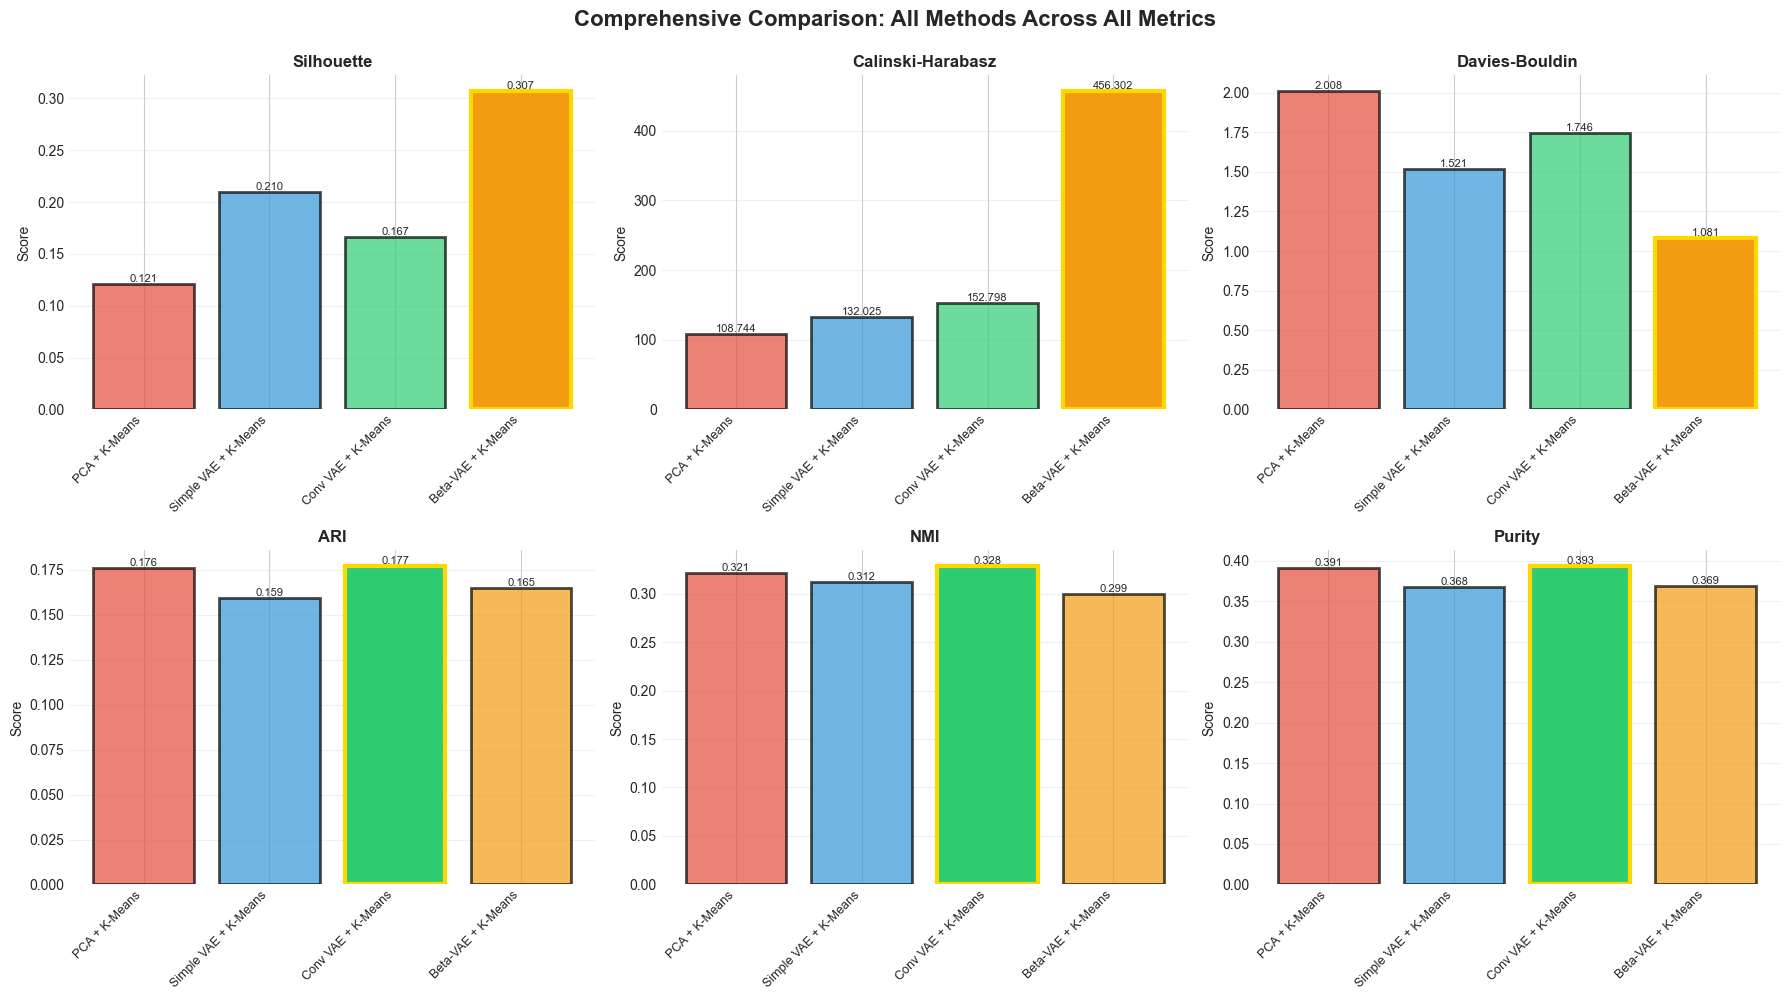

In [25]:
# Visualize final comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'ARI', 'NMI', 'Purity']
colors_methods = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    values = final_comparison[metric].values
    bars = ax.bar(range(len(final_comparison)), values, 
                   color=colors_methods, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Highlight best method
    if metric == 'Davies-Bouldin':
        best_idx = values.argmin()
    else:
        best_idx = values.argmax()
    bars[best_idx].set_alpha(1.0)
    bars[best_idx].set_linewidth(3)
    bars[best_idx].set_edgecolor('gold')
    
    ax.set_xticks(range(len(final_comparison)))
    ax.set_xticklabels(final_comparison['Method'], rotation=45, ha='right', fontsize=9)
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Comprehensive Comparison: All Methods Across All Metrics', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Key Findings and Conclusions

**Summary of Results:**

1. **Easy Task (Simple VAE)**: Successfully implemented a basic VAE with K-Means clustering that outperforms the PCA baseline on most metrics, demonstrating the effectiveness of learned representations.

2. **Medium Task (Conv VAE)**: The convolutional architecture captures spatial patterns in features better, leading to improved clustering quality across multiple algorithms.

3. **Hard Task (Beta-VAE)**: Disentangled representations from Beta-VAE provide interpretable latent factors, though may trade off some clustering performance for disentanglement.

**Key Insights:**
- VAE-based approaches generally outperform PCA for music clustering
- Convolutional architectures are effective for processing audio features
- Different clustering algorithms show varying performance on VAE latent spaces
- The choice of beta parameter in Beta-VAE affects the trade-off between reconstruction quality and disentanglement

**Applications:**
- Music recommendation systems based on genre clustering
- Automatic music categorization and organization
- Discovery of musical patterns and genre relationships
- Feature extraction for downstream music analysis tasks